### Handle the imports

In [1]:
import sys
sys.path.append("/Users/srothmei/Documents/TVB-Pypeline/")

In [2]:
import numpy as np
from nipype import Node, Workflow
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces import freesurfer, fsl
from nipype.interfaces.io import DataFinder

from bm_functions import compute_functional_connectivity

import logging

### Start the logging

In [3]:
logger = logging.getLogger('interface')
logger.setLevel(logging.INFO)
# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
# add formatter to ch
ch.setFormatter(formatter)
# add ch to logger
logger.addHandler(ch)

### Define Input- and Output-Node

In [56]:
# Inputs:
# -----------
# raw_files : Path-string to the folder containing the raw DICOM files
# subject_folder : Path-String to the folder containg the already processed subject data i.e. the path where 
#                the results of this step are also stored
inputNode = Node(IdentityInterface(fields = ['subID',
                                            'raw_files',
                                             'subject_folder',
                                            'parcellation_mask',
                                            'brainmask']), 
                 name = 'input_node')


outputNode = Node(IdentityInterface(fields = ['mat_file']),
                  name = 'output_node')

## Debug

In [ ]:
thePath = '/Users/srothmei/Desktop/charite/toronto/QL_20120814/'
default_feat_file = '/Users/srothmei/Documents/TVB-empirical-data-pipeline/featConfig/default.fsf'

bold_file = thePath + 'bold/bold.nii.gz'
bold_folder = '/Users/srothmei/Desktop/charite/toronto/Adalberto/debug/'

featDir = '/Users/srothmei/Desktop/charite/toronto/Adalberto/debug/featDir.feat/'

### Define Filenames

In [30]:
fileNames = {
    'bold_file': 'bold.nii.gz',
    'parcellation_2_func': 'parc_2_func.nii.gz',
    'func_2_anat': 'exfunc2anat_6DOF.nii.gz',
    'func_2_anat_mat': 'exfunc2anat_6DOF.mat',
    'anat_2_func_mat': 'anat2exfunc_6DOF.mat',
    'segstat_sum_file': 'segstat_summary.txt',
    'avgwf_file': 'segstat_average_ROI_timeseries.dat'
}

### Utility Functions

In [5]:
def folder_maker(pathName, folderName=None):
    if folderName is None:
        folderName = 'bold'
    
    import os
    if os.path.exists(pathName + '/' + folderName):
        os.makedirs(pathName + '/' + folderName)
        
    return pathName + '/' + folderName

folderMaker = Node(Function(input_names = ['path_name', 'folder_name'],
                                output_names = ['folder_path'],
                                function = folder_maker),
                        name='folder_maker')

def fileNameBuilder(path, fname):
    return path + fname       


### Convert Images from various formats to NifTi

In [6]:
rawFinderNode = Node(DataFinder(match_regex = '.*\.dcm'), name = 'DICOM_Finder')

convertNode = Node(freesurfer.preprocess.MRIConvert(), name = 'DICOM2Nii')
convertNode.inputs.out_type = 'niigz'
convertNode.inputs.out_orientation = 'RAS'

### Run FSLs feat

In [24]:
def run_feat(bold_file, bold_folder):
    from nipype.interfaces.fsl import ImageStats, FEAT, Info
    from shutil import copyfile
    import re, fileinput
    from bm_functions import gen_default_feat_config

    fslFilename = bold_folder + 'feat.fsf'

    # Get the number of voxels in the 4D file
    statComp = ImageStats()
    statComp.inputs.in_file = bold_file
    statComp.inputs.op_string = '-v'

    numVox = int(statComp.run().outputs.out_stat[0])

    # Get the number of raw volumes
    statComp.inputs.split_4d = True

    numVol = np.shape(statComp.run().outputs.out_stat)[0]

    # Generate the file
    standard_T1_brain = Info.standard_image('MNI152_T1_2mm_brain')
    theString = gen_default_feat_config(bold_folder, bold_file, brainmask_file, standard_T1_brain, numVox, numVol)
    with open(fslFilename,'w') as out_file:
        out_file.write(theString)
    out_file.close()   

    # Run feat using the previously manipulated config
    runFeat = FEAT(fsf_file = fslFilename)
    # Run and pass back the foldername
    return runFeat.run().outputs.feat_dir

featNode = Node(Function(input_names=['bold_file', 'default_feat_file', 'bold_folder'],
                        output_names=['feat_dir'],
                        function=run_feat),
                name = 'FSL_feat')

## Generate parcellated ROI-Timeseries

In [47]:
#Make a new subfolder
#subFolder = featDir + '/freesurfer'
#if os.path.exists(subFolder):
#        os.makedirs(subFolder)
        
#Register example-func to freesurfer brainmask
exfunc2anat = Node(fsl.FLIRT(bins=256, searchr_x=[90,90], searchr_y=[90,90], searchr_z=[90,90],
                       cost='corratio', interp='trilinear', dof=6),
                  name = 'Func_2_Anat')

#invert transformation
invt = Node(fsl.ConvertXFM(invert_xfm=True),
            name = 'invert_transf')

#transform roimask to functional space using FLIRT (using Nearest Neighbor Interpolation for roimask)
roimask2func = Node(fsl.FLIRT(padding_size=0, interp='nearestneighbour', apply_xfm=True),
                    name = 'roimask_2_func')

#Export average region time-series
ss = Node(freesurfer.SegStats(), name = 'SegStats')
#ss.inputs.avgwf_txt_file = True

### Preprocess the data before computing the FC

In [9]:
def segstat_shaping(aparc_stats):
    import os, re
    from shutil import copyfile
    
    #Remove all comment lines from the files (important for later MATLAB/OCTAVE import!)
    clearedFileName = os.path.dirname(aparc_stats) + '/aparc_stats_tmp.txt'
    copyfile(aparc_stats, clearedFileName)
    with open(tmpFileName,'w') as out_file:
        with open(aparc_stats,'r') as in_file:
            for line in in_file:
                if line.startswith('#'):
                    line = ''
                else:
                    line = re.sub('Seg','',line.strip()) + '\n'
                out_file.write(line)
    out_file.close()
    in_file.close()
    
    return clearedFileName

segstatPost = Node(Function(input_names = ['aparc_stats'],
                           output_names = ['clearedFileName'],
                           function = segstat_shaping),
                  name = 'segstat_Postprocesser')

### Compute the FC

In [10]:
compFCNode = Node(Function(input_names = ['path', 'subName', 'avgwf_txt_file', 'summary_file_cleared'],
                          output_names = ['matfile_name'],
                          function = compute_functional_connectivity), 
                 name = 'compute_FC')

## Define the Workflow

In [59]:
wf = Workflow('fMRI_Processing')

wf.connect([(inputNode, folderMaker, [('subject_folder', 'pathName')])])

wf.connect([(inputNode, rawFinderNode, [('raw_files', 'root_paths')])])

wf.connect([(rawFinderNode, convertNode, [('out_paths', 'in_file')]),
           (folderMaker, convertNode, [(('folder_path', fileNameBuilder, fileNames['bold_file']), 'out_file')])])

wf.connect([(convertNode, featNode, [('out_file', 'bold_file')]),
           (folderMaker, featNode, [('folder_path', 'bold_folder')])])

wf.connect([(featNode, exfunc2anat, [(('feat_dir', fileNameBuilder, 'mean_func.nii.gz'), 'in_file')]),
           (inputNode, exfunc2anat, [('brainmask', 'reference')]),
           (folderMaker, exfunc2anat, [(('folder_path', fileNameBuilder, fileNames['func_2_anat']), 'out_file'),
                                      (('folder_path', fileNameBuilder, fileNames['func_2_anat_mat']), 'out_matrix_file')])])

wf.connect([(exfunc2anat, invt, [('out_matrix_file', 'in_file')]),
          (folderMaker, invt, [(('folder_path', fileNameBuilder, fileNames['anat_2_func_mat']), 'out_file')])])

wf.connect([(inputNode, roimask2func, [('parcellation_mask', 'in_file')]),
           (invt, roimask2func, [('out_file', 'in_matrix_file')]),
           (folderMaker, roimask2func, [(('folder_path', fileNameBuilder, fileNames['parcellation_2_func']), 'out_file')])])

wf.connect([(roimask2func, ss, [('out_file', 'segmentation_file')]),
           (folderMaker, ss, [(('folder_path', fileNameBuilder, fileNames['avgwf_file']), 'avgwf_txt_file')]),
           (featNode, ss, [(('feat_dir', fileNameBuilder, 'filtered_func_data.nii.gz'), 'in_file')]),
           (folderMaker, ss, [(('folder_path', fileNameBuilder, fileNames['segstat_sum_file']), 'summary_file')])])

wf.connect([(ss, segstatPost, [('summary_file', 'aparc_stats')])])

wf.connect([(segstatPost, compFCNode, [('clearedFileName' , 'summary_file_cleared')]),
           (ss, compFCNode, [('avgwf_txt_file', 'avgwf_txt_file')]),
           (inputNode, compFCNode, [('subID', 'subName')]),
           (folderMaker, compFCNode, [('folder_path', 'path')])])

wf.connect([(compFCNode, outputNode, [('matfile_name', 'mat_file')])])

## Draw the Workflow

INFO:workflow:Converting dotfile: /Users/srothmei/Documents/TVB-Pypeline/notebooks/fmri/workflow_graph.dot to png format


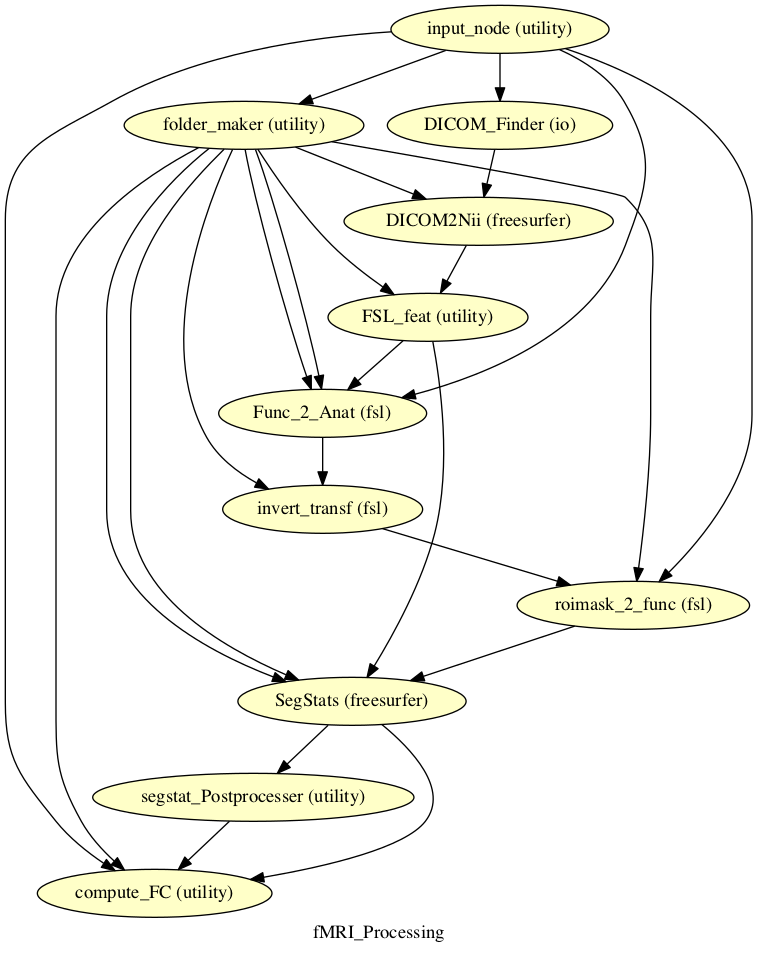

In [58]:
wf.write_graph("workflow_graph.dot", graph2use = 'colored')
from IPython.display import Image
Image(filename="workflow_graph.dot.png")